<a href="https://colab.research.google.com/github/jhryulab/neural_style_transfer/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd

import PIL
import PIL.Image

tf.__version__

'2.6.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
os.chdir('/content/drive/MyDrive/project/neural_style_transfer')

# Load content and style images

In [29]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis,:]
  return img

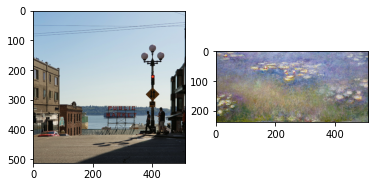

In [34]:
CONTENT_PATH = 'image/seattle.jpg'
STYLE_PATH = 'image/nymphea.jpg'

# content_image
content_image = load_img(CONTENT_PATH)
style_image = load_img(STYLE_PATH)

plt.subplot(1,2,1)
plt.imshow(tf.squeeze(content_image))
plt.subplot(1,2,2)
plt.imshow(tf.squeeze(style_image))

In [35]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

# Build content and style extractor

In [50]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False)

In [42]:
for layer in vgg.layers:
  print(layer.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


The paper used content representation on layer 'conv4 2' and the style representation on layers conv1 1, conv2 1, conv3 1, conv4 1 and conv5 1.

(wl = 1/5 in those layers, wl = 0 in all other layers) . The
ratio α/β was either 1 × 10−3
(Fig 3 B), 8 × 10−4
(Fig 3
C), 5 × 10−3
(Fig 3 D), or 5 × 10−4
(Fig 3 E, F).


In [60]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1',
                        'block2_conv1',
                        'block3_conv1',
                        'block4_conv1',
                        'block5_conv1']

In [49]:
vgg.get_layer('block4_conv2')

In [63]:
def make_extractor(layer_names):
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False)
  vgg.trainable = False

  inputs = vgg.input
  outputs = [vgg.get_layer(name).output for name in layer_names]

  extractor = tf.keras.Model(inputs, outputs)

  return extractor

In [64]:
content_extractor = make_extractor(content_layers)
content_representation = content_extractor(content_image)
# style_extractor = 